### Notebook baseado no pytorch.org 

Usando data augmentation, com esse notebook será capaz de aplicar e visualizar efeitos de áudio, filtros e RIR( room impulse response) e os codecs, no final será sintetizado noisy speech over phone from clean speech 

Reference: https://pytorch.org/audio/main/tutorials/audio_data_augmentation_tutorial.html

In [1]:
import librosa as lib
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchaudio as ta
from matplotlib.animation import FuncAnimation
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
from pydub import AudioSegment as AS
from torchaudio.utils import download_asset

In [2]:
def plot_waveform(wav , sr , titulo , xlim=None):
    wav = wav.numpy()
    num_channels , num_frames = wav.shape
    
    time_axis = torch.arange(0 , num_frames ) / sr 
    
    fig , ax = plt.subplots(num_channels , 1)
    if num_channels == 1:
        ax = [ax]
        
    for c in range(num_channels):
        ax[c].plot(time_axis , wav[c] , linewidth=1)
        ax[c].grid(True)
        if num_channels > 1:
            ax[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            ax[c].set_xlim(xlim)
    fig.suptitle(titulo)
    
    
def plot_espectograma(spec , titulo = 'Espectograma' , ylabel="freq_bin" , ax=None):
    if ax is None:
        _ , ax = plt.subplot(1 , 1)
    
    ax.set_ylabel(ylabel)
    ax.imshow(lib.power_to_db(spec) , origin="lower" , aspect="auto", interpolation="nearest")
    
def plot_spectogram(wav , sr , titulo="Spectogram", xlim=None):
    wav = wav.numpy()
    
    n_channels, _ = wav.shape 
    
    fig , ax = plt.subplots(n_channels , 1)
    if n_channels == 1:
        ax = [ax]
    
    for c in range(n_channels):
        ax[c].specgram(wav[c] , Fs=sr)
        
        if n_channels > 1:
            ax[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            ax[c].set_xlim(xlim)
    fig.suptitle(titulo)
    
    
def plot_fbank(fbank , title=None):
    fig , axs = plt.subplot(1,1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank , aspect="auto")
    axs.set_ylabel("frequencia bin")
    axs.set_xlabel("mel bin")
    
     

In [3]:
wav , sr = lib.load("jadna.ogg")

print(wav)

print(type(wav))

print(wav.conjugate())

original = AS.from_ogg("jadna.ogg")
original.export("jadna.wav" , format="wav")




[ 2.1537044e-06 -3.0066230e-06  9.3615847e-07 ...  2.9842078e-04
 -1.7777437e-03 -1.2821642e-03]
<class 'numpy.ndarray'>
[ 2.1537044e-06 -3.0066230e-06  9.3615847e-07 ...  2.9842078e-04
 -1.7777437e-03 -1.2821642e-03]


<_io.BufferedRandom name='jadna.wav'>

In [4]:
wav , sr = torchaudio.load("jadna.wav" , channels_first=False)

effect = ",".join(
    [
        "lowpass=frequency=300:poles=1",
        "atempo=0.8",
        "aecho=in_gain=0.8:out_gain=0.9:delays=200:decays=0.3|delays=400:decays=0.3"
    ],
)

def aplica(wav , sr , effect):
    effector = torchaudio.io.AudioEffector(effect=effect)
    return effector.apply(wav , sr)

wav2 = aplica(wav , sr , effect)

print(wav.shape , sr)
print(wav2.shape , sr)

torchaudio.save("jadnaProcessed.wav", wav2.T, sr, channels_first=True)

torch.Size([715096, 1]) 48000
torch.Size([903186, 1]) 48000


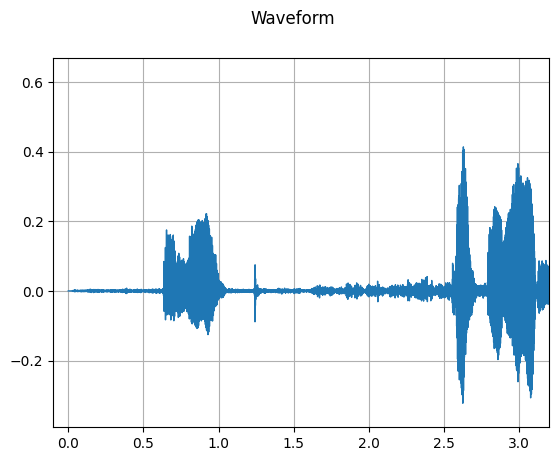

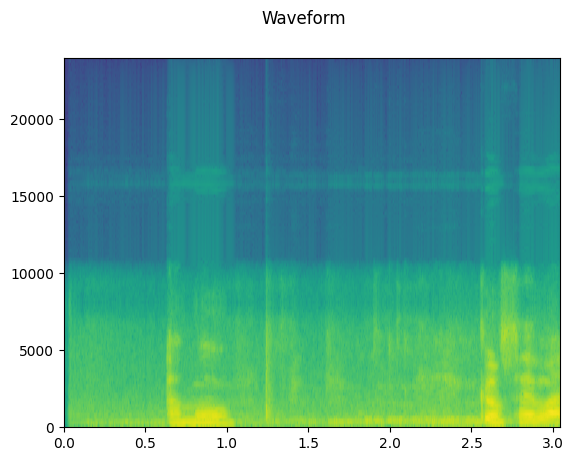

In [5]:
plot_waveform(wav.T , sr , titulo="Waveform" ,xlim=(-0.1 , 3.2))
plot_spectogram(wav.T , sr , titulo="Waveform" , xlim=(0 , 3.04))


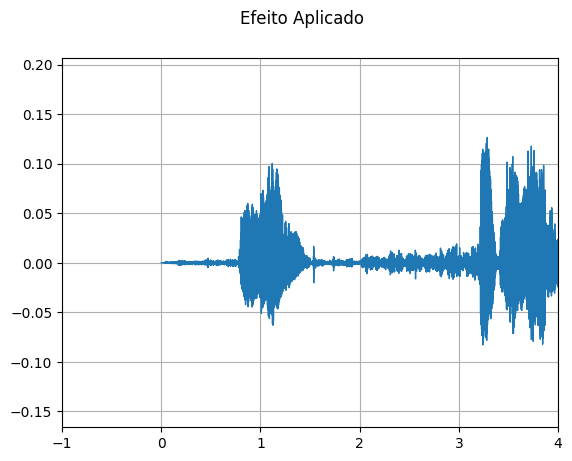

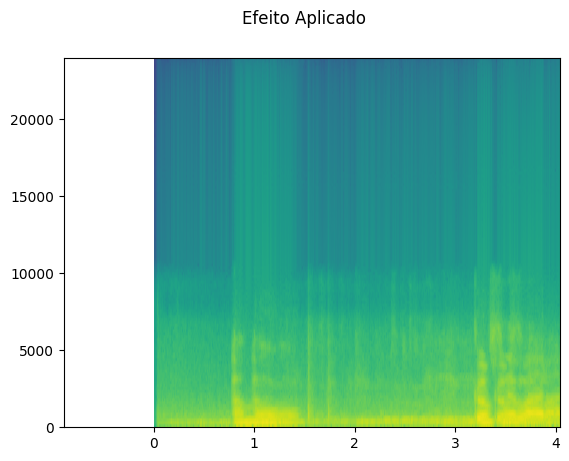

In [6]:
plot_waveform(wav2.T , sr , titulo="Efeito Aplicado" , xlim=(-1 , 4))
plot_spectogram(wav2.T , sr , titulo="Efeito Aplicado" , xlim=(-0.9 , 4.04))


### Coletando o RIR 

Na base o RIR é o som acústico no contexto de áudio, aquele som acústico no ambiente

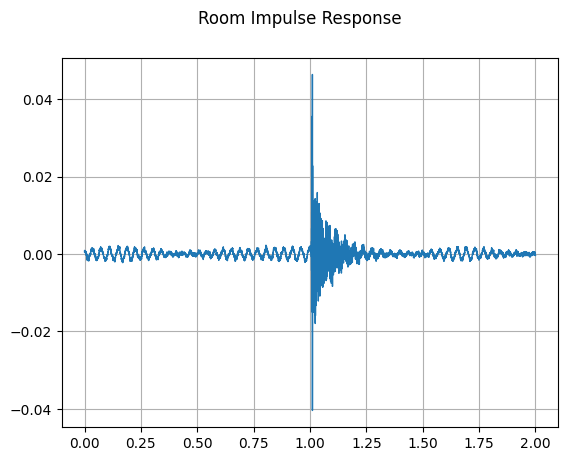

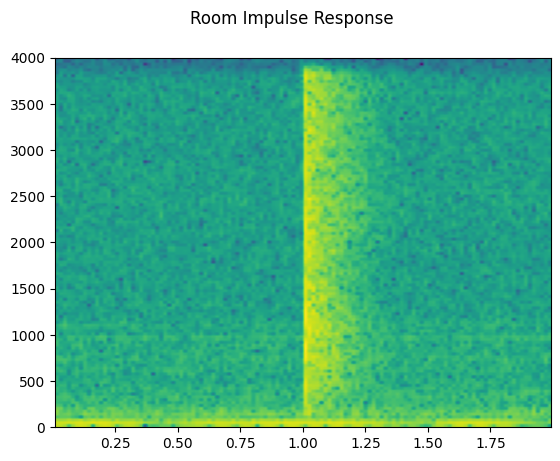

In [7]:
SAMPLE_RIR = download_asset("tutorial-assets/Lab41-SRI-VOiCES-rm1-impulse-mc01-stu-clo-8000hz.wav")

rir_raw , sr = torchaudio.load(SAMPLE_RIR)

plot_waveform(rir_raw , sr , titulo="Room Impulse Response ")
plot_spectogram(rir_raw , sr , titulo="Room Impulse Response ")

Fazendo agora um slice no áudio para pegar a parte mais sigificante 

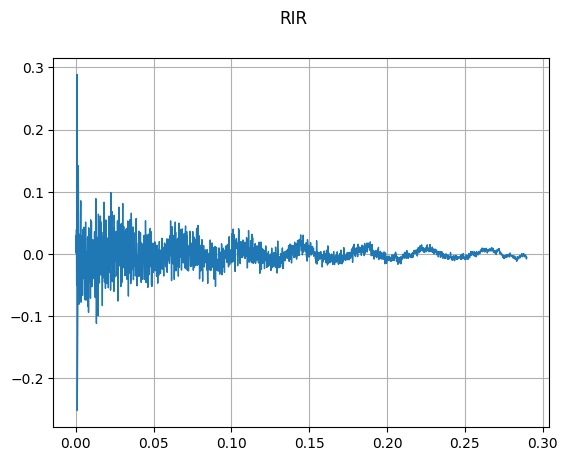

In [9]:
rir = rir_raw[: , int(sr * 1.01) : int(sr * 1.3)]
rir = rir / torch.linalg.vector_norm(rir , ord=2)

plot_waveform(rir , sr , titulo="RIR")

Aplicando a fftconvolve para convolucionar o sinal de RIR 

/home/rafael/anaconda3/envs/figas2/lib/python3.11/site-packages/matplotlib/axes/_axes.py:8089: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


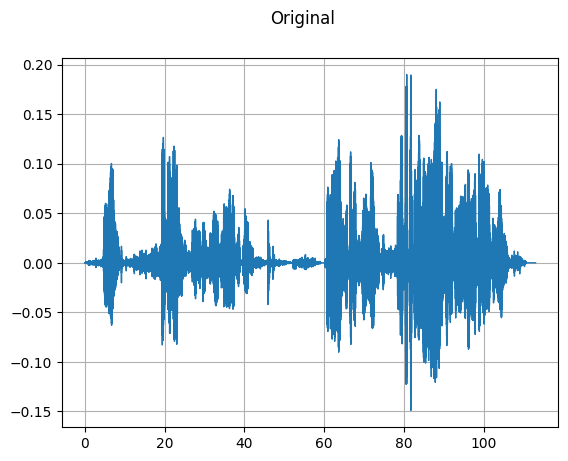

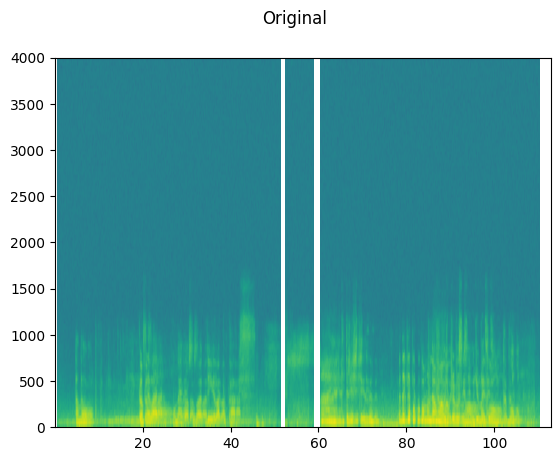

In [10]:
speech , _ = torchaudio.load("jadnaProcessed.wav")

augmented = F.fftconvolve(speech , rir)

plot_waveform(speech , sr , titulo="Original")
plot_spectogram(speech , sr , titulo="Original")

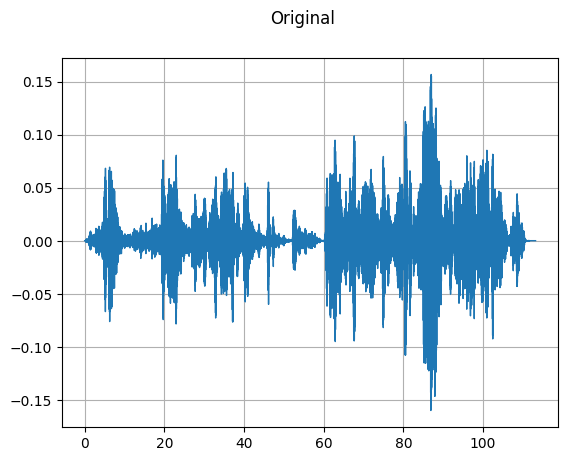

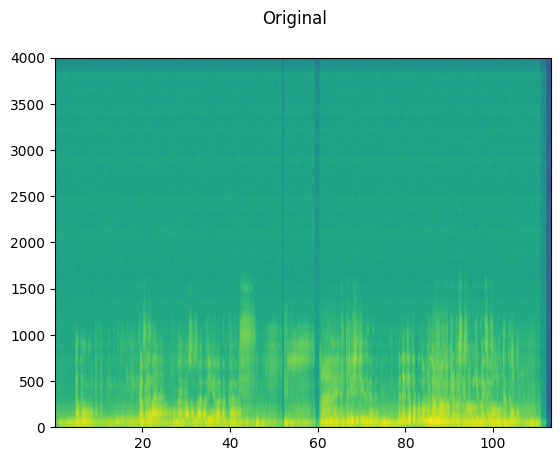

In [11]:
plot_waveform(augmented , sr , titulo="Original")
plot_spectogram(augmented , sr , titulo="Original")